In [1]:
#import tensorflow
import warnings

warnings.filterwarnings ('ignore')
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
def calculate_adj_r2(r_sq, k, n):

    adj_r = 1-((1-r_sq)*(n-1)/(n-k-1))
   
    return adj_r

Using TensorFlow backend.


In [2]:
def LabelEncode(df_local):
    for col in df_local.columns:
        col_dict = {}
        if df_local[col].dtype!='object':
            continue
        elif df_local[col].dtype=='object':
            col2=df_local[col].unique()
            z=0
            for i in col2:
                col_dict[i]=z
                z+=1
            df_local[col]=df_local[col].map(col_dict)
        
            
    return df_local

data=pd.read_csv("auto-mpg.csv")
data.head()

print(data.columns)
data.fillna(0)
print(data.columns)
df_encode = LabelEncode(data)
df_encode.shape

X = ['cylinders', 'displacement', 'horsepower', 'weight',
        'model year', 'origin', 'car name' ]
#X=['weight', 'model year', 'origin']

Y = ['mpg']
# X_train, X_test, Y_train, Y_test = train_test_split(df_encode[X],df_encode[Y], test_size=0.25, random_state=42, shuffle=True)
# df_train=pd.concat([X_train, Y_train], axis=1).reindex(X_train.index)
# df_test=pd.concat([X_test, Y_test], axis=1).reindex(X_test.index)
# print(df_train.size)
# print(df_test.size)
X_train, X_test, Y_train, Y_test = train_test_split(df_encode[X],df_encode[Y], test_size=0.25, random_state=42, shuffle=True)


Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')
Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')


In [3]:
# Scale both training and testing input data

X_train = preprocessing.scale(X_train)

X_test = preprocessing.scale(X_test)

activation_list = ['linear','relu', 'sigmoid', 'tanh', 'elu','softmax','softplus','softsign','selu','exponential']


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                104       
_________________________________________________________________
dense_2 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_3 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


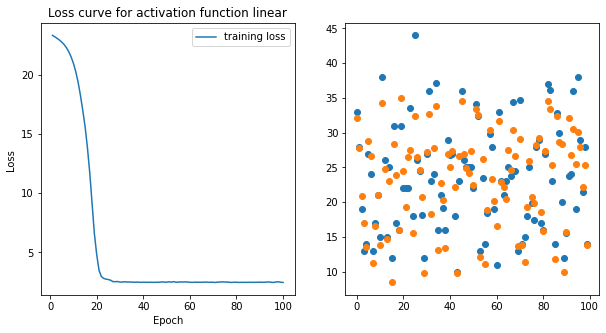

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 13)                104       
_________________________________________________________________
dense_6 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_7 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


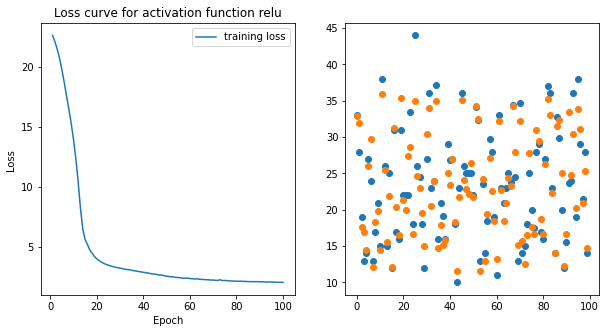

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 13)                104       
_________________________________________________________________
dense_10 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_11 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


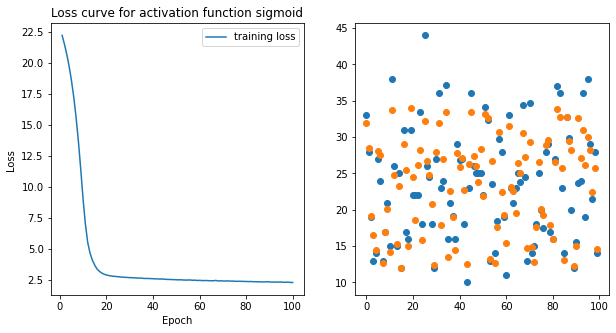

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 13)                104       
_________________________________________________________________
dense_14 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_15 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


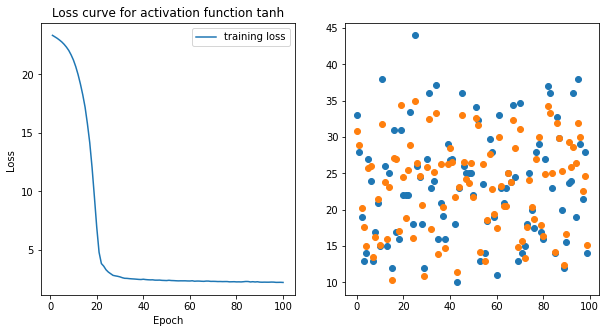

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 13)                104       
_________________________________________________________________
dense_18 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_19 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


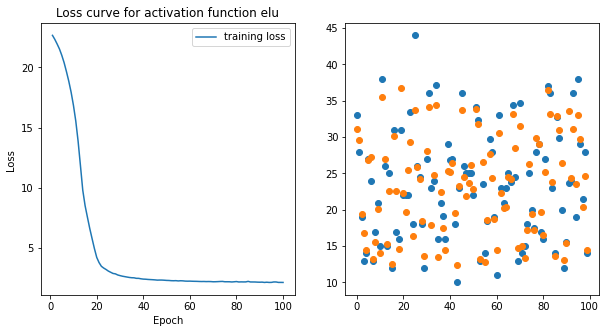

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 13)                104       
_________________________________________________________________
dense_22 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_23 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


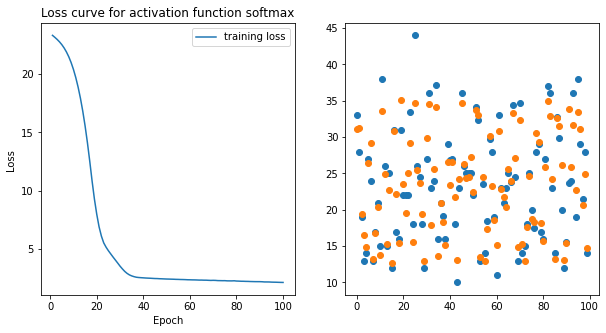

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 13)                104       
_________________________________________________________________
dense_26 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_27 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


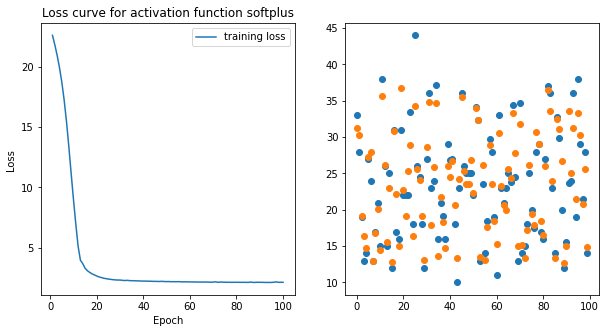

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 13)                104       
_________________________________________________________________
dense_30 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_31 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


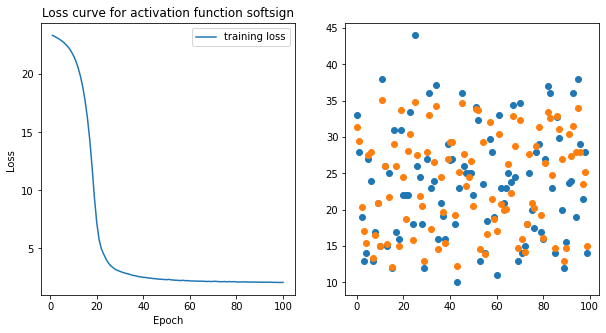

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 13)                104       
_________________________________________________________________
dense_34 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_35 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


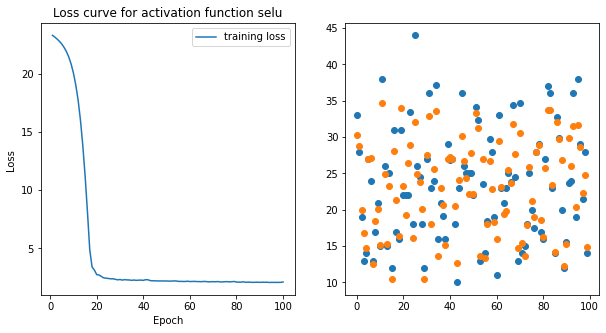

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 13)                104       
_________________________________________________________________
dense_38 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_39 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 14        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


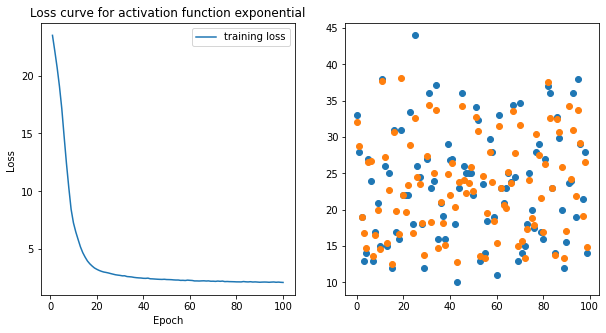

In [4]:
r2_list = []
r2_bar_list=[]
for i in activation_list:
    model = Sequential()
    model.add(Dense(13, input_dim=len(X), activation=i))
    model.add(Dense(13))
    model.add(Dense(13))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mae', metrics=['mae']) 
    #model.compile(Adam(lr=0.003), 'mean_squared_error')

    print(model.summary())

    #Fits model
    history = model.fit(X_train, Y_train, epochs = 100, validation_split = 0.1,verbose = 0)
    history_dict=history.history
    print(history_dict.keys())
    #Plots model's training cost/loss and model's validation split cost/loss
    loss_values = history_dict['loss']
    val_loss_values=history_dict['val_loss']
    #plt.figure()
#     plt.plot(loss_values,label='training loss')
#     plt.show()
    # Runs model (the one with the activation function, although this doesn't really matter as they perform the same) 
    # with its current weights on the training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)



    epochs = range(1, len(loss_values) + 1)


    r2=r2_score(Y_test, y_test_pred)
    r2_list.append(r2)
    r2_bar_list.append(calculate_adj_r2(r2, len(X),len(X_test)))
    plt.subplots(1,2,figsize=(10,5))
    plt.subplot(121)
    plt.title('Loss curve for activation function '+ i)
    plt.xlabel('Epoch')
    plt.ylabel('Loss ')
    plt.plot(epochs, loss_values, '-', label='training loss')
    plt.legend()
    plt.subplot(122)
    plt.scatter(x=range(len(X_test)), y=Y_test)
    plt.scatter(x=range(len(X_test)), y=y_test_pred)
    plt.show()

   

In [5]:
print("Neural Net 4 Layers")
for i in range(len(activation_list)):
    print("R2 value for using activation function %s : %s", activation_list[i], r2_list[i])
    print("Ad R2 value for using activation function %s : %s", activation_list[i], r2_bar_list[i])

Neural Net 4 Layers
R2 value for using activation function %s : %s linear 0.8286706546270322
Ad R2 value for using activation function %s : %s linear 0.8156347261747412
R2 value for using activation function %s : %s relu 0.8764239283212497
Ad R2 value for using activation function %s : %s relu 0.8670214011283013
R2 value for using activation function %s : %s sigmoid 0.8276983810576408
Ad R2 value for using activation function %s : %s sigmoid 0.8145884752685483
R2 value for using activation function %s : %s tanh 0.84313576113543
Ad R2 value for using activation function %s : %s tanh 0.8312004386131258
R2 value for using activation function %s : %s elu 0.8766427538516368
Ad R2 value for using activation function %s : %s elu 0.8672568764273049
R2 value for using activation function %s : %s softmax 0.8784992042652376
Ad R2 value for using activation function %s : %s softmax 0.8692545785028101
R2 value for using activation function %s : %s softplus 0.8830687196222659
Ad R2 value for using a

In [ ]:
r2_list = []
r2_bar_list=[]
r2_cv_list=[]
col_list = [X[0]]
r_max=0
for i in X[1:]:
    model_cv = Sequential()    
    model_cv.add(Dense(13, input_dim=len(col_list), activation='relu'))
    model_cv.add(Dense(13))
    model_cv.add(Dense(13))
    model_cv.add(Dense(1))

    model_cv.compile(optimizer='adam', loss='mae', metrics=['mae']) 
    X_train = preprocessing.scale(df_encode[col_list])

    history = model_cv.fit(X_train, df_encode[Y], epochs = 100, validation_split = 0.2,verbose = 0, batch_size=10)
    history_dict=history.history
    y_test_pred = model_cv.predict(X_train)
    r2=r2_score(df_encode[Y], y_test_pred)
    r2_cv_list.append(r2)
    model = Sequential()    
    model.add(Dense(13, input_dim=len(col_list), activation='relu'))
    model.add(Dense(13))
    model.add(Dense(13))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mae', metrics=['mae']) 
    history = model.fit(X_train, df_encode[Y], epochs = 100, verbose = 0, batch_size=10)
    history_dict=history.history
    y_test_pred = model.predict(X_train)
    r2=r2_score(df_encode[Y], y_test_pred)
    if r2>r_max:
        r_max=r2
        col_list.append(i)
    r2_list.append(r2)
    adjusted_r2 = calculate_adj_r2(r2, X_train.shape[0],len(col_list))
    r2_bar_list.append(adjusted_r2)

    
plt.subplots(1,2,figsize=(10,5))
plt.suptitle("R2 Graph", fontsize=20)
plt.subplot(121)
plt.plot( range(len(col_list)), r2_list,label="r2")
plt.plot( range(len(col_list)), r2_bar_list,label="r2 bar")
plt.legend()
plt.subplot(122)
plt.plot( range(len(col_list)), r2_cv_list,label="r2 cross validation")
plt.legend()
plt.show()
    
    
print(col_list)

In [ ]:
!jupyter nbconvert Neural_autompg_XL.ipynb --to=pdf --TemplateExporter.exclude_input=True